In [ ]:

#  Parent-child web scraping involves navigating through a hierarchy of web elements, where a parent element contains one 
#  or more child elements. This scenario often occurs when you click on a link to access detailed information on a webpage 
#  and then navigate back to the previous page to extract more links or information.

#  Identify the Parent Element: The parent element is typically the one containing the links or information you want to 
#  interact with. This could be a list of links, a table, or any other container element.

#  Click on the Parent Element: Use a web scraping tool like Selenium to find and interact with the parent element. You can 
#  locate it using various methods such as XPath, CSS selectors, or class names.

#  Extract Child Elements: Once you've clicked on the parent element and accessed a new page or section containing more 
#  detailed information (the child elements), you can extract the desired information using similar methods as before. 
#  This may involve finding specific elements, text, or attributes within the child elements.

#  Navigate Back to the Parent Page: After extracting the information from the child elements, you typically want to 
#  navigate back to the parent page to continue scraping additional links or information. You can use the browser's 
#  built-in back button or Selenium's back() method to achieve this.
      

In [ ]:

import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from bs4 import BeautifulSoup
import pandas as pd

# Start a new Chrome session
driver = webdriver.Chrome()

# Maximize the browser window
driver.maximize_window()

# Navigate to the website
driver.get("https://locations.chipotle.com/")

# Fetch state abbreviations
# You can easily get all the states you want data for. We are just illustrating 4 states here. 
# It takes a long time to do all 49 states! As of this date, there are no Chipoltes in Alaska! 
state_abbreviations = ["ar", "id", "ok", "vt", "wy"]

# Initialize an empty list to store address details
address_list = []

# Iterate through state abbreviations
for state_abbr in state_abbreviations:
    print(f"State: {state_abbr.upper()}")
    
    # Construct the state URL
    state_url = f"https://locations.chipotle.com/{state_abbr}"
    print(f"State URL: {state_url}")

    # Navigate to the state URL
    driver.get(state_url)
    
    # Fetch city links outside the loop
    city_links = find_city_links()

    # Iterate through city links
    for i in range(len(city_links)):
        # Re-locate the city links before interacting with them
        city_links = find_city_links()

        # Retrieve the city link based on the index
        city_link = city_links[i]

        # Extract the city name
        city_name = city_link.text.strip()
        print(f"City: {city_name}")

        # Scroll to the city link
        actions = ActionChains(driver)
        actions.move_to_element(city_link).perform()

        # Click on the city link to drill down
        city_link.click()
        
        # Wait for the page to load fully
        time.sleep(2)
        
        # Wait until the location details appear or look for LocationName
        try:
            WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'Core-address')))
            # Extract address details
            # Get the HTML content of the page
            city_html_content = driver.page_source
                    
            # Use BeautifulSoup to extract address details directly
            soup = BeautifulSoup(city_html_content, 'html.parser')
            street_address = soup.find(class_='c-address-street-1').get_text(strip=True)
            city = soup.find(class_='c-address-city').get_text(strip=True)
            state = soup.find(class_='c-address-state').get_text(strip=True)
            postal_code = soup.find(class_='c-address-postal-code').get_text(strip=True)
            address_details = f"{street_address}\n{city}, {state} {postal_code}"
            print(f"Address Details: {address_details}")
            address_list.append({
                'State': state_abbr.upper(),
                'City': city_name,
                'Address': address_details
            })
        except TimeoutException:
            # print("No Core-address found. Looking for LocationName.")
            location_name_links = driver.find_elements(By.XPATH, "//a[@class='Teaser-titleLink']")
            if location_name_links:
                # Create a list to store unique href attributes
                href_list = []
                for location_name_link in location_name_links:
                    href = location_name_link.get_attribute("href")
                    if href not in href_list:
                        href_list.append(href)
                
                # Iterate through the unique href attributes
                for href in href_list:
                    # Click on the href link
                    driver.get(href)
                    
                    # Wait for the page to load fully
                    time.sleep(2)
                    
                    # Wait until the location details appear
                    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'Core-address')))
                    
                    # Get the HTML content of the page
                    city_html_content = driver.page_source
                    
                    # Use BeautifulSoup to extract address details directly
                    soup = BeautifulSoup(city_html_content, 'html.parser')
                    street_address = soup.find(class_='c-address-street-1').get_text(strip=True)
                    city = soup.find(class_='c-address-city').get_text(strip=True)
                    state = soup.find(class_='c-address-state').get_text(strip=True)
                    postal_code = soup.find(class_='c-address-postal-code').get_text(strip=True)
                    address_details = f"{street_address}\n{city}, {state} {postal_code}"
                    print(f"Address Details: {address_details}")
                    address_list.append({
                        'State': state_abbr.upper(),
                        'City': city_name,
                        'Address': address_details
                    })
                    driver.back()
        
        # Go back to the city page
        driver.back()

        # Wait for the page to load fully
        time.sleep(2)
        
        # Wait until the city page loads and re-fetch city links
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'Directory-listLinkText')))

# Close the browser session
driver.quit()

# Convert the list of address details into a DataFrame
data = pd.DataFrame(address_list)
print(data.shape)
print(data.head())


State: AR
State URL: https://locations.chipotle.com/ar
City: BENTONVILLE
Address Details: 2400 SE Walton Blvd
Bentonville, AR 72712
City: CONWAY
Address Details: 915 E Oak St
Conway, AR 72032
City: FAYETTEVILLE
Address Details: 3379 N College Ave
Fayetteville, AR 72703
Address Details: 550 W Dickson St
Fayetteville, AR 72701
City: FORT SMITH
Address Details: 6205 Rogers Ave
Fort Smith, AR 72903
City: JONESBORO
Address Details: 1737 S Caraway Rd
Jonesboro, AR 72401
City: LITTLE ROCK
Address Details: 100 S University Ave
Little Rock, AR 72205
Address Details: 11525 Cantrell Rd
Little Rock, AR 72212
Address Details: 12524 Chenal Pkwy
Little Rock, AR 72211
City: NORTH LITTLE ROCK
Address Details: 3917 McCain Blvd
North Little Rock, AR 72116
State: ID
State URL: https://locations.chipotle.com/id
City: BOISE
Address Details: 205 N Milwaukee St
Boise, ID 83704
Address Details: 305 S 6th St
Boise, ID 83702
Address Details: 702 E Boise Ave
Boise, ID 83706
Address Details: 7610 W State Street
Bo

In [56]:

# Now let's dsolve a traveling salesman problem (TSP). We want to find the shortest route between all the addresses in each state.
# To solve the traveling salesman problem and find the shortest route between all addresses in each state, you can use optimization 
# algorithms like the "nearest neighbor" algorithm or the "2-opt" algorithm. 

import pandas as pd
import googlemaps

# Let's copy the data variable (dataframe) to a new variable (another dataframe) because if you get a lot of restaurant addresses, it takes 
# quite a log time to run. If there is a mistake calcualting distances between addresses, we can re-run the process quickly and easily, but we
# don't want to have a mistake wipe out data in the dattaframe that we waited a long time to create.
df = data



# Initialize the Google Maps client
gmaps = googlemaps.Client(key='you_api_key_goes_here')

# Function to calculate driving distance between two addresses
def calculate_distance(address1, address2):
    result = gmaps.distance_matrix(address1, address2, mode='driving')
    distance = result['rows'][0]['elements'][0]['distance']['value']  # distance in meters
    return distance / 1609.34  # convert meters to miles

# Function to find nearest neighbor starting from a given node
def find_nearest_neighbor(node, unvisited, addresses):
    nearest_neighbor = None
    min_distance = float('inf')
    for neighbor in unvisited:
        distance = calculate_distance(addresses[node], addresses[neighbor])
        if distance < min_distance:
            min_distance = distance
            nearest_neighbor = neighbor
    return nearest_neighbor, min_distance

# Group addresses by state
grouped = df.groupby('State')

# Iterate over groups and find optimal route for each state
for state, group in grouped:
    print(f"State: {state}")
    addresses = group['Address'].tolist()
    
    # Initialize variables for route and running distance
    route = []
    cumulative_distance = 0
    
    # Start from the first address and iteratively find the nearest neighbor
    current_node = 0
    route.append(addresses[current_node])
    unvisited = set(range(1, len(addresses)))
    while unvisited:
        nearest_neighbor, distance = find_nearest_neighbor(current_node, unvisited, addresses)
        route.append(addresses[nearest_neighbor])
        unvisited.remove(nearest_neighbor)
        cumulative_distance += distance
        current_node = nearest_neighbor
    
    # Return to the starting point to complete the route
    route.append(route[0])
    cumulative_distance += calculate_distance(addresses[current_node], addresses[0])
    
    # Print the optimal route
    print("Optimal Route:")
    running_distance = 0
    for i, address in enumerate(route[:-1]):
        if i > 0:
            running_distance += calculate_distance(route[i-1], address)
        print(f"{i+1}. {address}")
        print(f"   Running Distance: {running_distance:.2f} miles")
        

State: AR
Optimal Route:
1. 2400 SE Walton Blvd
Bentonville, AR 72712
   Running Distance: 0.00 miles
2. 3379 N College Ave
Fayetteville, AR 72703
   Running Distance: 19.73 miles
3. 550 W Dickson St
Fayetteville, AR 72701
   Running Distance: 23.74 miles
4. 6205 Rogers Ave
Fort Smith, AR 72903
   Running Distance: 83.58 miles
5. 915 E Oak St
Conway, AR 72032
   Running Distance: 211.41 miles
6. 11525 Cantrell Rd
Little Rock, AR 72212
   Running Distance: 237.83 miles
7. 12524 Chenal Pkwy
Little Rock, AR 72211
   Running Distance: 242.61 miles
8. 100 S University Ave
Little Rock, AR 72205
   Running Distance: 246.73 miles
9. 3917 McCain Blvd
North Little Rock, AR 72116
   Running Distance: 258.50 miles
10. 1737 S Caraway Rd
Jonesboro, AR 72401
   Running Distance: 382.44 miles
State: ID
Optimal Route:
1. 205 N Milwaukee St
Boise, ID 83704
   Running Distance: 0.00 miles
2. 7610 W State Street
Boise, ID 83714
   Running Distance: 5.16 miles
3. 305 S 6th St
Boise, ID 83702
   Running Dis

In [ ]:

# Let's look at the states of AR, VT, and WY. Google Maps limits users to 10 destinations at a time, so we need to find states with 
# <=10 Chipolte restaurants.

# For AR we found 382.44 miles
# For VT we found 69.62 miles
# For WY we found 51.05 miles


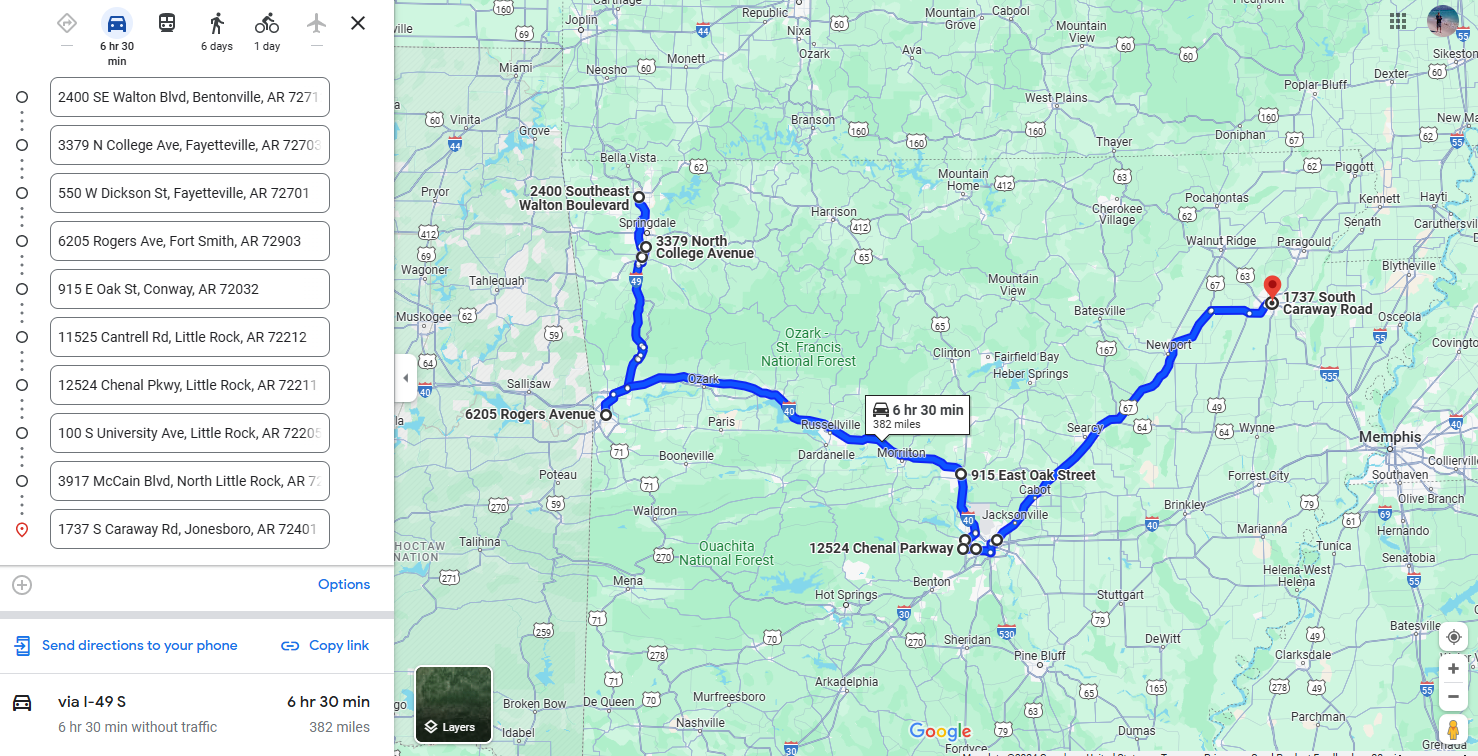

In [57]:

from IPython.display import Image
from IPython.core.display import HTML 
PATH = "C:\\Users\\"
Image(filename = PATH + "AR.PNG")


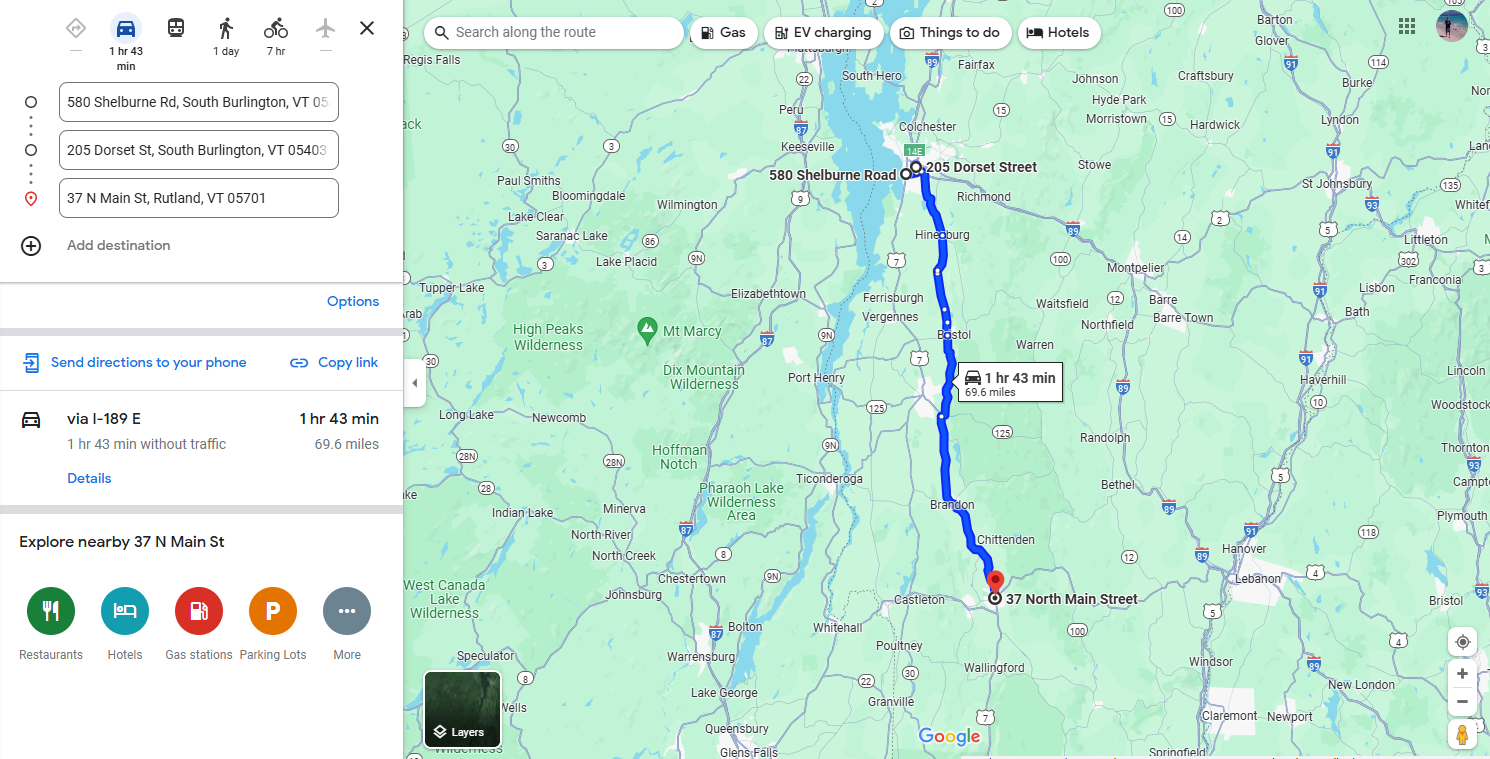

In [58]:

from IPython.display import Image
from IPython.core.display import HTML 
PATH = "C:\\Users\\"
Image(filename = PATH + "VT.PNG")


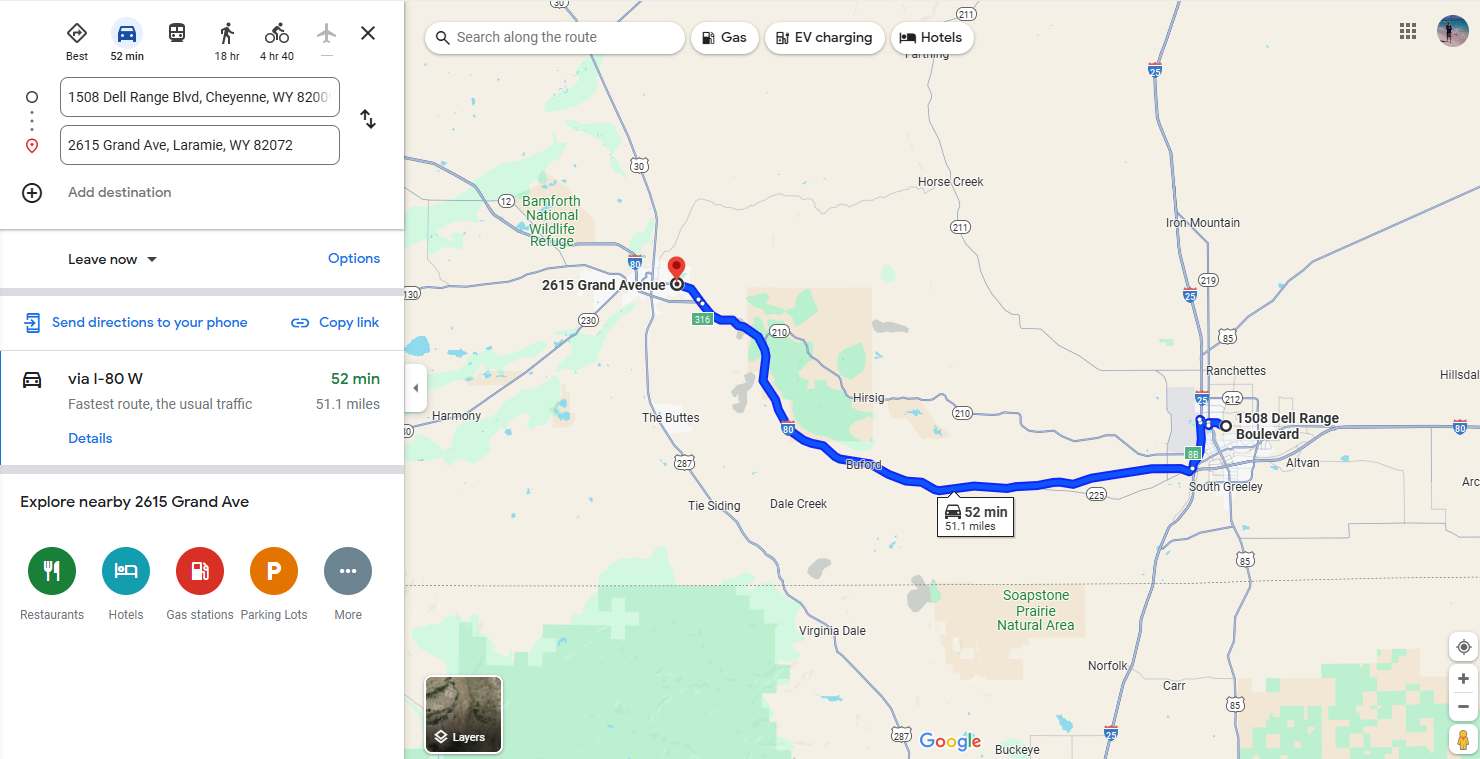

In [59]:

from IPython.display import Image
from IPython.core.display import HTML 
PATH = "C:\\Users\\"
Image(filename = PATH + "WY.PNG")


In [ ]:

# Now, I have no idea if Chipolte divides up it's supply chain by states, or more likely by regions, which will incorporate the retaurants that are the 
# closest together into the same cluster, and others into different, disparate clusters, but I'm guessing it's by region, rather than by state.
# I don't have access to this kind of information, so I can't make a dcision based on this knowledge. Anyway, if it's by region, which I suspect it
# is, we would simply group by region to find the optimal routes for all supply chain management decisions.

# To be clear, the computational complexity of generating and evaluating all possible permutations of addresses for each state is very high. 
# As the number of addresses increases, the number of permutations grows factorially, leading to a significant increase in computation time.

# To address this issue, we can use heuristic algorithms like the nearest neighbor algorithm or genetic algorithms, which provide approximate 
# solutions to the traveling salesman problem much more efficiently than exhaustively checking all permutations.


In [ ]:

# END!!!
